# Load Data

In [1]:



import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Plot Data

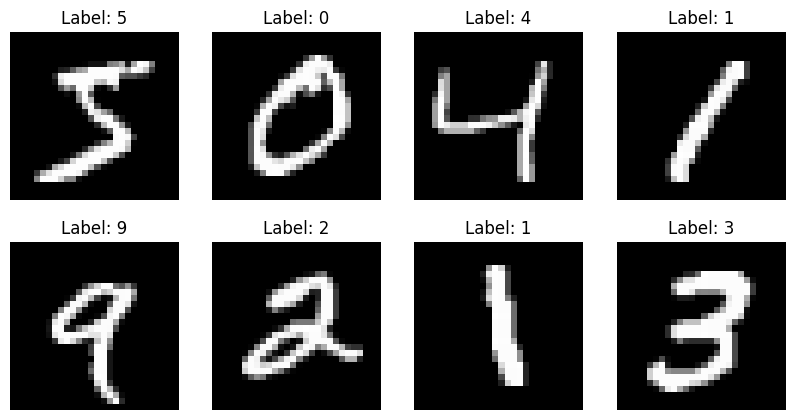

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.show()

In [4]:
# Check the shape of the data
# Each image is 28 x 28 pixels
print(x_train[1].shape)

(28, 28)


# Random Forest

## Data Prep

In [5]:
# Many machine learning models expect data to be in a 2D table, where each row is a sample and each column is a feature.
# We can flatten the 28x28 images into a single row of 784 pixels.

# So, first we need to prepare/alter the images so that a random forest can use them.
# The random forest will use the pixel values as features, so give it a dataset of flat vectors like
# the one we used for the fashion_mnist example.

x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(x_train_flat.shape)
print(y_train.shape)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

(60000, 784)
(60000,)


In [6]:
# There are 10 classes in the MNIST dataset, just like the fashion_MNIST.
# You need to select 3 classes to train your model on. You get to pick the classes you want to use, but 
# Please choose classes that are similar to each other.
# For example, you could choose 3, 5, and 8. Or 4, 7, 9. Or other combinations that you deam appropriate.
# Please don't choose digits that are easy to tell apart, like 0, 1, and 5. Or 1, 2, and 3.

# You can totally copy code over from the fmnist_examples notebook and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objective and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data

train_filter = (y_train == 3) | (y_train == 5) | (y_train == 8)
x_train_3classes = x_train_flat[train_filter]
y_train_3classes = y_train[train_filter]
test_filter = (y_test == 3) | (y_test == 5) | (y_test == 8)
x_test_3classes = x_test_flat[test_filter]
y_test_3classes = y_test[test_filter]



# Maybe check the shape of the data is correct

print(x_train_3classes.shape)
print(y_train_3classes.shape)
print(x_test_3classes.shape)
print(y_test_3classes.shape)


(17403, 784)
(17403,)
(2876, 784)
(2876,)


## Simple Model Fit

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit the model
rf.fit(x_train_3classes, y_train_3classes)

y_test_pred = rf.predict(x_test_3classes)

# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test_3classes, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')


Test Accuracy: 0.9801808066759388


# Tune Model Fit

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(x_train_3classes, y_train_3classes)

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_rf = random_search.best_estimator_

# Generate predictions on the test set and calculate the overall accuracy of the model on the test set
y_test_pred_tuned = best_rf.predict(x_test_3classes)
test_accuracy_tuned = accuracy_score(y_test_3classes, y_test_pred_tuned)

print(f'Best Parameters: {best_params}')
print(f'Test Accuracy after tuning: {test_accuracy_tuned}')

# Does tuning the model improve the accuracy? How much?
# Was the tuning accuracy worth the extra time?
print(f'Improvement in accuracy: {test_accuracy_tuned - test_accuracy}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Test Accuracy after tuning: 0.9815716272600834
Improvement in accuracy: 0.0013908205841446364


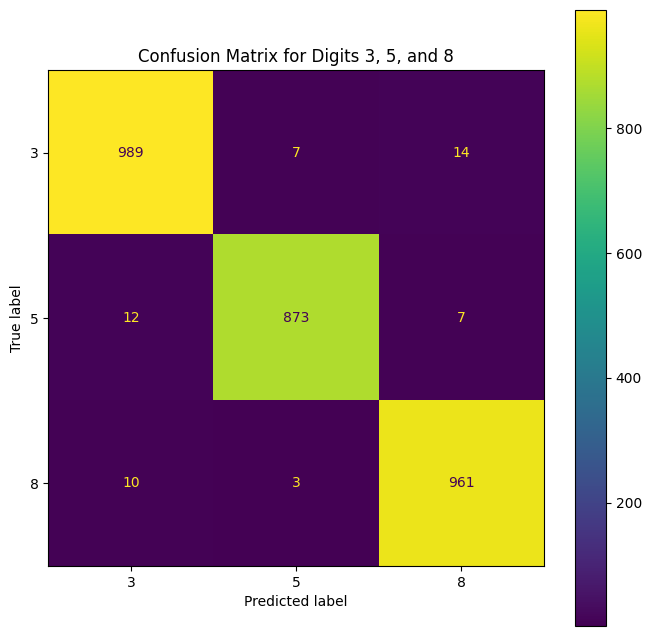

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_3classes, y_test_pred_tuned)

# Create and plot confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[3, 5, 8])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title('Confusion Matrix for Digits 3, 5, and 8')
plt.show()
# What do you notice about the confusion matrix?
#3 and 8 are most often confused with eachother. In general most things are predicted to be 3 overall, including 5 and 8.

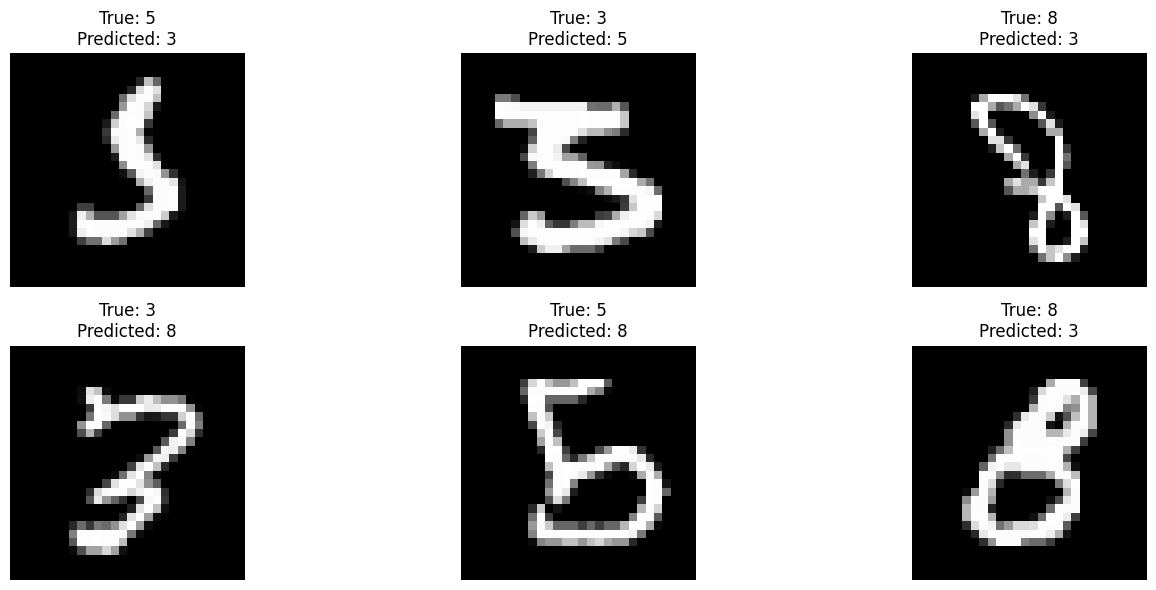

In [11]:
import numpy as np

# Find indices of misclassified images
misclassified_idx = np.where(y_test_pred_tuned != y_test_3classes)[0]

# Plot a few misclassified images
plt.figure(figsize=(15, 6))
for i, idx in enumerate(misclassified_idx[:6]):  # Show first 6 misclassifications
    plt.subplot(2, 3, i + 1)
    # Reshape the flattened image back to 28x28
    img = x_test_3classes[idx].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f'True: {y_test_3classes[idx]}\nPredicted: {y_test_pred_tuned[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Can you see why the model made the misclassifications it did?
# The 3's and 5's look very similar, but it's hard to tell why the 8's are being misclassified as 3's. Maybe its a limitaton to what model we are using for this.